In [ ]:
import csv
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import concatenate, Input
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
import json

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from jupyterthemes import jtplot
jtplot.style()
sns.set_context("poster")
# plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [3]:
#we want to predict the steering angle for the next second of video. Here we 
#skip each 3 frames and predict on them
num_predict_ahead_frames_to_use = 90
predict_ahead_step_rate = 3
num_predict_ahead_frames = num_predict_ahead_frames_to_use//predict_ahead_step_rate


In [4]:
def pipeline(images, sensors, steering_throttle):
    # go through and create a vectors for look ahead, let try though 10
    print('processing these bits')
    steering = [x[0] for x in steering_throttle]
    steering_buffer = list(steering[:num_predict_ahead_frames_to_use])
    steer_train = []

    for y in steering[num_predict_ahead_frames_to_use:]:
        steer_train.append(steering_buffer[::predict_ahead_step_rate])
        steering_buffer.append(y)
        steering_buffer = steering_buffer[1:]    
        
    #trip up the other inputs    
    images_train = images[:-num_predict_ahead_frames_to_use]
    sensors_train = sensors[:-num_predict_ahead_frames_to_use]
    steer_train = np.array(steer_train)

    return images_train, sensors_train, steer_train

In [5]:
X_train = []
S_train = []
y_train = []

drives = ['V79_shadow_run_office_3.pkl']
for drive in drives:
    with open('{}'.format(drive), 'rb') as f:
        data = pickle.load(f,encoding='latin1')
        
    X, S, Y = (data['images'], 
        data['sensors'], 
        data['steering_throttle'].astype(np.float64))
    X_train.extend(X) #images
    S_train.extend(S) #sensors
    y_train.extend(Y) #steering
    
    #flip left to right for augmented data
    X, S, Y = (np.array([np.fliplr(x) for x in data['images']]),
        data['sensors'],
        np.negative(data['steering_throttle'].astype(np.float64)))
               
    X_train.extend(X) #images
    S_train.extend(S) #sensors
    y_train.extend(Y) #steering
    
X_train = np.array(X_train)
S_train = np.array(S_train)
y_train = np.array(y_train)

In [6]:
print(X_train.shape, S_train.shape, y_train.shape)

(368, 80, 320, 3) (368, 2) (368, 30)


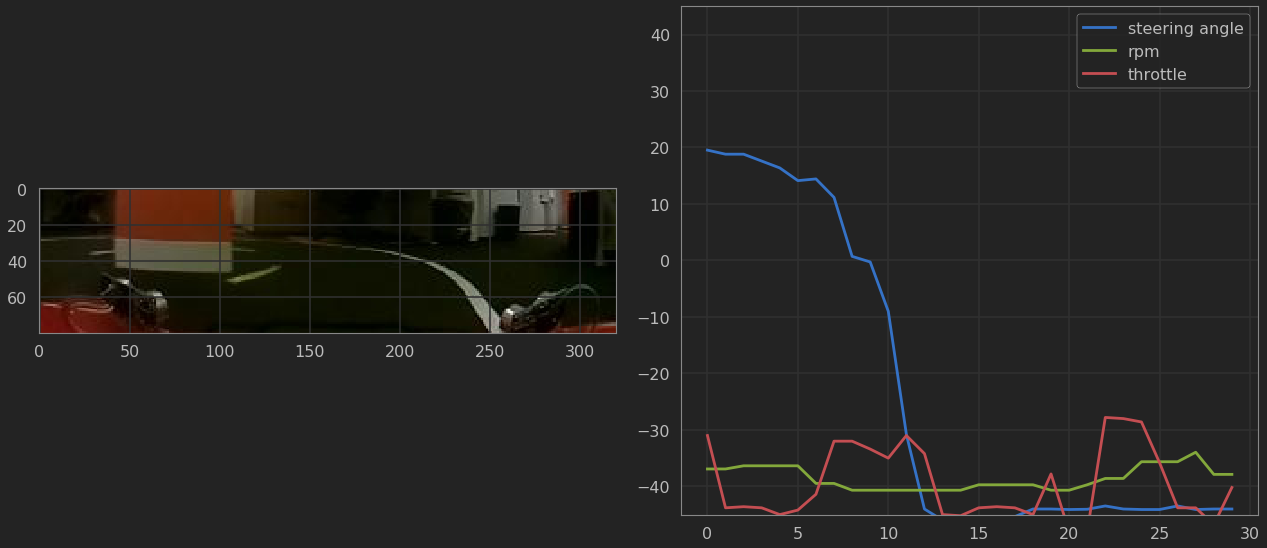

In [10]:
#view some images
frame = 100

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(X_train[frame])
plt.subplot(122)
plt.plot(y_train[frame] * 45, label="steering angle")
plt.plot(S_train[frame: frame + 90:3, 0] * 100 - 45, label="rpm")
plt.plot(S_train[frame: frame + 90:3, 1] * 100 - 45, label="throttle")
plt.ylim((-45,45))
plt.legend()
plt.tight_layout()
plt.show()


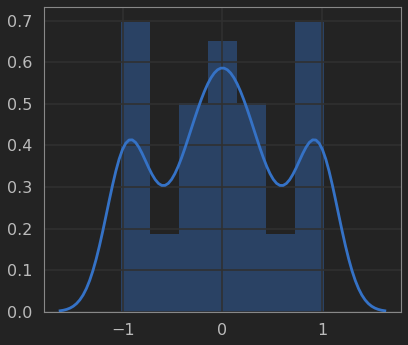

In [11]:
# lets look at the RPM data
sns.distplot(y_train[:,0])

In [12]:
def create_model():
    model = Sequential()
    
    #inputs
    image_input = Input(shape=(80, 320, 3), name='image_input', dtype='float32')
    sensor_input = Input(shape=(1,), name='sensor_input', dtype='float32')
    
    # preprocess
    X = Lambda(lambda x: x/255.0 - 0.5, name="lambda_1")(image_input)
    
    # conv1 layer
    X = Convolution2D(32, (5, 5), name="conv_1")(X)
    X = MaxPooling2D((2, 2), name="pool_1")(X)
    X = Activation('relu',name="relu_1")(X)
    
    # conv2 layer
    X = Convolution2D(64, (5, 5), name="conv_2")(X)
    X = MaxPooling2D((3, 3), name="pool_2")(X)
    X = Activation('relu', name="relu_2")(X)
    
    # conv3 layer
    X = Convolution2D(128, (3, 3), name="conv_3")(X)
    X = MaxPooling2D((2, 2), name="pool_3")(X)
    X = Activation('relu', name="relu_3")(X)

    # conv4 layer
    X = Convolution2D(128, (3, 3), name="conv_4")(X)
    X = MaxPooling2D((2, 2), name="pool_4")(X)
    X = Activation('relu', name="relu_4")(X)

    #add fully connected layers
    X = Flatten(name="flat_1")(X)
    
    #add in the speed, here we may add in other variables such 
    # as the last several throttle / speed/ steering angles, and other sensors
    X = concatenate([X, sensor_input], name="concate_1")
    
    # fc1
    X = Dense(1024, name="dnse_1")(X)
    X = Dropout(0.5, name="dropout_1")(X)
    X = Activation('relu', name="dense_relu_1")(X)
    
    # fc2
    X = Dense(128, name="dnse_2")(X)
    X = Dropout(0.5, name="dropout_2")(X)
    X = Activation('relu', name="dense_relu_2")(X)
    
    # fc2
    X = Dense(64, name="dnse_3")(X)
    X = Dropout(0.5, name="dropout_3")(X)
    X = Activation('relu', name="dense_relu_3")(X)
    
    #outputs are the next 10 frames
    steer_outputs = []
    for i in range(num_predict_ahead_frames):
        steer_output = Dense(1, name='steer_output_{}'.format(i))(X)
        steer_outputs.append(steer_output)
    
    

    #model = Model(inputs=[image_input, sensor_input], outputs=[steer_output, throttle_output])
    model = Model(inputs=[image_input, sensor_input], outputs=steer_outputs)

    loss_def = {"steer_output_{}".format(i) : "mse" for i in range(num_predict_ahead_frames)}
    loss_weight_def = {"steer_output_{}".format(i) : 1.0 for i in range(num_predict_ahead_frames)}
    
    # note, setting the loss weight to favor steering
    model.compile(optimizer='adam', loss=loss_def, loss_weights=loss_weight_def)

    return model

In [13]:
#create the model and save it as json
model = create_model()
with open("model.json", "w") as f:
    json.dump(model.to_json(), f)

In [14]:
#loading the model
from keras.models import model_from_yaml, model_from_json
with open("model.json") as f:
    model = model_from_json(json.load(f))
    model.compile(loss="mse", optimizer="adam")
#     model.load_weights("office_set_predict_ahead_90_2.h5")  #<--last run

In [15]:
y_train.shape

(368, 30)

In [16]:
y_output = {"steer_output_{}".format(i) : y_train[:,i] for i in range(num_predict_ahead_frames)}

In [17]:
hist = []
for i in range(0,50):
    print("{} --------------".format(i))
    h = model.fit({'image_input': X_train, 'sensor_input': S_train[:,0]}, y_output, 
                  shuffle=True, epochs=10, validation_split=.3, batch_size=128)
    hist.append(h.history)
    with open('history_90.json', 'w') as f:
            json.dump(hist, f)
            
    if i % 5 == 0:
        model.save("office_set_predict_ahead_90_with_rpm_{}.h5".format(i))
    

0 --------------
Train on 257 samples, validate on 111 samples
Epoch 1/10
257/257 [==============================] - 17s - loss: 12.1211 - steer_output_0_loss: 0.4450 - steer_output_1_loss: 0.4221 - steer_output_2_loss: 0.4049 - steer_output_3_loss: 0.3944 - steer_output_4_loss: 0.3918 - steer_output_5_loss: 0.3744 - steer_output_6_loss: 0.3628 - steer_output_7_loss: 0.3556 - steer_output_8_loss: 0.3700 - steer_output_9_loss: 0.3713 - steer_output_10_loss: 0.3846 - steer_output_11_loss: 0.4079 - steer_output_12_loss: 0.4052 - steer_output_13_loss: 0.4031 - steer_output_14_loss: 0.4032 - steer_output_15_loss: 0.4044 - steer_output_16_loss: 0.4148 - steer_output_17_loss: 0.4108 - steer_output_18_loss: 0.3989 - steer_output_19_loss: 0.4176 - steer_output_20_loss: 0.4339 - steer_output_21_loss: 0.3950 - steer_output_22_loss: 0.4250 - steer_output_23_loss: 0.4203 - steer_output_24_loss: 0.4205 - steer_output_25_loss: 0.4307 - steer_output_26_loss: 0.4249 - steer_output_27_loss: 0.4175 - ste

KeyboardInterrupt: 

In [ ]:
model.save("office_set_predict_ahead_90_with_rpm_temp.h5")


In [ ]:
predicted = np.array(model.predict({'image_input': X_train, 'sensor_input': S_train[:,0]}))

In [ ]:
predicted.shape


In [ ]:
# visual actual vs predicted
plt.figure(figsize=(400,10))
plt.plot(y_train, label="train")
plt.plot(predicted[0, :,0], label="predicted")
plt.legend()
plt.xticks(np.arange(0,len(X_train), 1000))
plt.show()

In [ ]:
#inference
frame = 5305


img = X_train[frame]
actual = yy_train[frame] * 45
predicted_angle = [x[frame][0] * 45 for x in predicted]


plt.subplot(211)
plt.imshow(X_train[frame])
plt.subplot(212)
plt.plot(np.arange(0,90,3),actual, label="actual")
plt.plot(np.arange(0,90,3),predicted_angle,  label="predicted")
plt.plot(np.arange(0,90,3),S_train[frame: frame + 90:3, 0] * 500 - 45, label="rpm")
plt.ylim((-45,45))
plt.legend()
plt.title("predicted vs actual steering angle for the next \n30frames (1second at 60fps) @ {} RPM".format(S_train[frame][0] * 5000))
plt.show()

print(yy_train[frame])